In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# Menyembunyikan semua peringatan
warnings.filterwarnings('ignore')


# Read Data

In [37]:
# Memuat dataset
df = pd.read_csv('restaurant_menu_optimization_data.csv')

In [38]:
# Display first few rows
df.head()

,RestaurantID,MenuCategory,MenuItem,Ingredients,Price,Profitability
0,R003,Beverages,Soda,['confidential'],2.55,Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",11.12,Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",18.66,High
3,R003,Main Course,Chicken Alfredo,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",29.55,High
4,R002,Main Course,Grilled Steak,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",17.73,Medium


In [39]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RestaurantID   1000 non-null   object 
 1   MenuCategory   1000 non-null   object 
 2   MenuItem       1000 non-null   object 
 3   Ingredients    1000 non-null   object 
 4   Price          1000 non-null   float64
 5   Profitability  1000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


In [40]:
# Numerical Data

df.describe()

,Price
count,1000.00000
mean,12.81801
std,7.41713
min,2.01000
25%,4.86750
50%,12.53500
75%,17.69000
max,29.84000


In [41]:
# Categorical Data

df.describe(include = 'object')

,RestaurantID,MenuCategory,MenuItem,Ingredients,Profitability
count,1000,1000,1000,1000,1000
unique,3,4,16,4,3
top,R001,Beverages,Iced Tea,['confidential'],Medium
freq,354,264,72,264,495


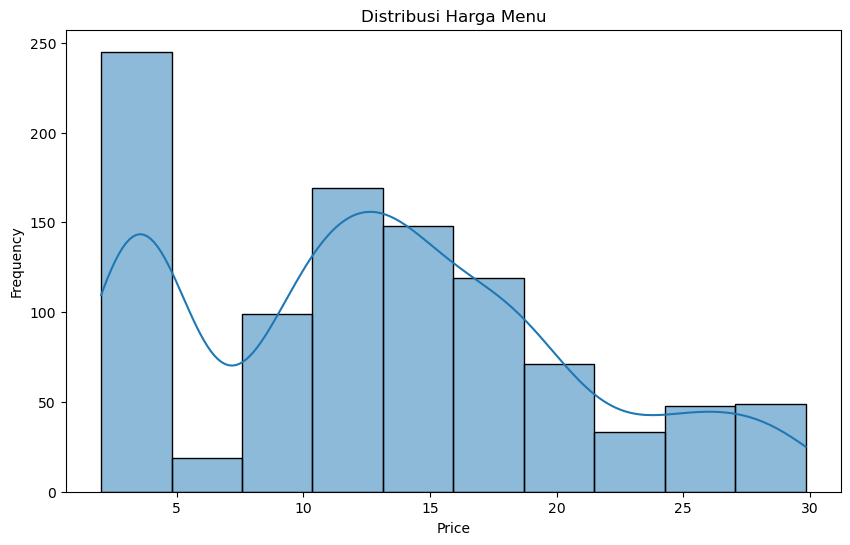

In [42]:
# Visualisasi distribusi harga
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=10, kde=True)
plt.title('Distribusi Harga Menu')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


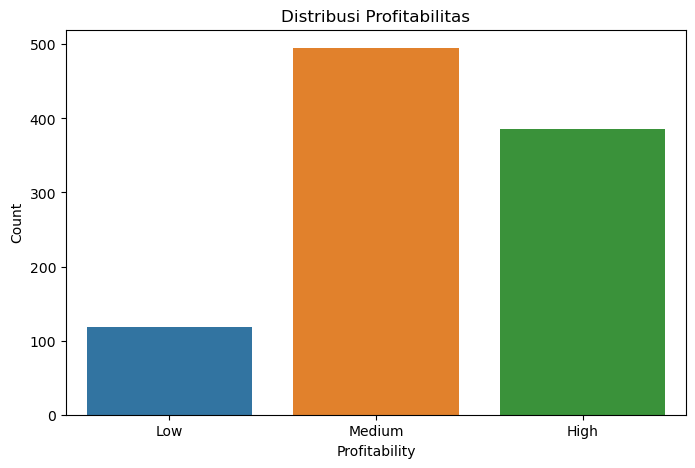

In [43]:
# Visualisasi profitabilitas
plt.figure(figsize=(8, 5))
sns.countplot(x='Profitability', data=df)
plt.title('Distribusi Profitabilitas')
plt.xlabel('Profitability')
plt.ylabel('Count')
plt.show()

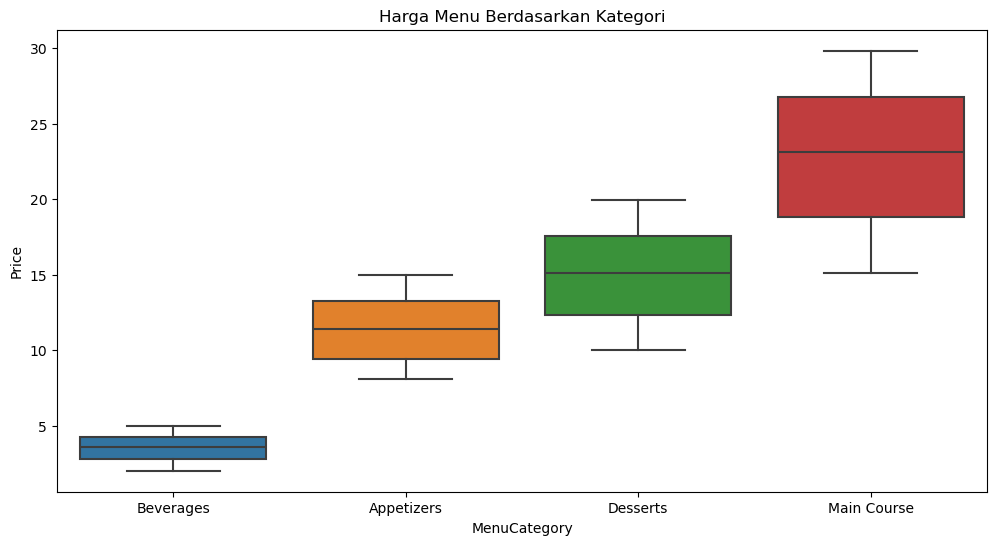

In [44]:
# Visualisasi harga berdasarkan kategori menu
plt.figure(figsize=(12, 6))
sns.boxplot(x='MenuCategory', y='Price', data=df)
plt.title('Harga Menu Berdasarkan Kategori')
plt.xlabel('MenuCategory')
plt.ylabel('Price')
plt.show()

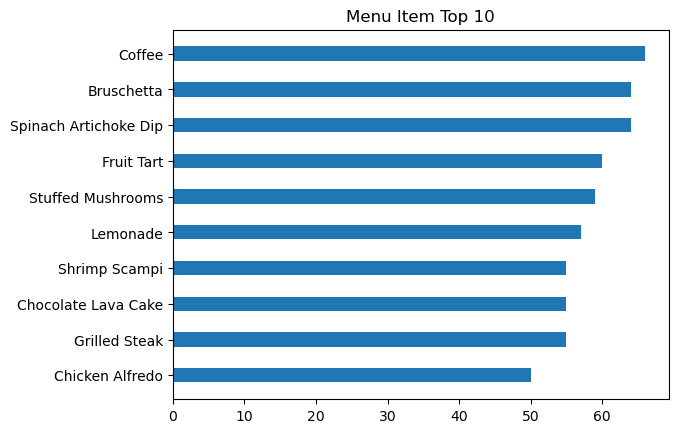

In [45]:
# MenuItem

data = df['MenuItem'].value_counts(ascending = True).head(10)
plt.barh(data.index , data.values , height = 0.4)
plt.title('Menu Item Top 10')
plt.show()

# Stage 2: Data Preprocessing

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

# Definisi DataFrame dan pemilihan kolom
df_select = df[['MenuCategory', 'MenuItem','Price', 'Profitability']]

In [47]:
# Separate
train_df = df_select.iloc[:978, :]
test_df = df_select.iloc[978:,:]

print("Train data size:", train_df.shape)
print("Test data size:", test_df.shape)

Train data size: (978, 4)
Test data size: (22, 4)


In [48]:
# Cek missing values
print("Missing values:\n", df_select.isnull().sum())

Missing values:
 MenuCategory     0
MenuItem         0
Price            0
Profitability    0
dtype: int64


In [49]:
# Pisahkan fitur (x) dan target (y)
x = train_df.drop(columns='Profitability', axis=1)
y = train_df['Profitability']

In [50]:
# Split data menjadi data latih dan data uji
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1234, test_size=0.2)

In [51]:
# Inisialisasi ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ("cat_menu_category", OneHotEncoder(drop='first'), ['MenuCategory']),
        ("cat_menu_item", CountVectorizer(), 'MenuItem'),
        ("num_price", MinMaxScaler(), ['Price'])
    ],
    remainder='passthrough'
)

In [52]:
# Transformasi data
x_train_trans = ct.fit_transform(x_train)
x_test_trans = ct.transform(x_test)

In [53]:
# Memeriksa hasil
print(x_train_trans.shape)
print(x_test_trans.shape)

(782, 35)
(196, 35)


# Stage 3: Model Training and Comparison

# Model Random Forest

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [55]:
# Example for Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', ct),
    ('classifier', RandomForestClassifier())
])
rf_pipeline.fit(x_train, y_train)
y_pred_rf = rf_pipeline.predict(x_test)

In [56]:
# Evaluasi
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest - Akurasi: {accuracy_rf:.4f}")
print(f"Random Forest - Presisi: {precision_rf:.4f}")
print(f"Random Forest - Recall: {recall_rf:.4f}")
print(f"Random Forest - Nilai F1: {f1_rf:.4f}")

Random Forest - Akurasi: 0.8776
Random Forest - Presisi: 0.8867
Random Forest - Recall: 0.8776
Random Forest - Nilai F1: 0.8806


In [57]:
# Cross-Validation
cv_scores_rf = cross_val_score(rf_pipeline, x_train, y_train, cv=5)
print(f"Random Forest Cross-Validation Score: {cv_scores_rf.mean():.4f}")

Random Forest Cross-Validation Score: 0.8466


In [58]:

# Definisikan parameter grid untuk Random Forest
params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 7],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 3],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}
# Inisialisasi GridSearchCV
gcv = GridSearchCV(estimator=rf_pipeline, param_grid=params, cv=5, scoring='accuracy', verbose=1)

# Latih model menggunakan GridSearchCV
gcv.fit(x_train, y_train)

# Dapatkan model terbaik
best = gcv.best_estimator_

# Tampilkan parameter terbaik
print(f"Best parameters found: {gcv.best_params_}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'classifier__max_depth': 7, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


# Model KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier

# Inisialisasi Pipeline untuk KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', ct),                 # Preprocessing dengan ColumnTransformer
    ('classifier', KNeighborsClassifier())    # KNN classifier
])

# Train KNN model
knn_pipeline.fit(x_train, y_train)

# Prediksi dengan model yang sudah dilatih
y_pred_knn = knn_pipeline.predict(x_test)

In [60]:
# Evaluasi
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f"KNN - Akurasi: {accuracy_knn:.4f}")
print(f"KNN - Presisi: {precision_knn:.4f}")
print(f"KNN - Recall: {recall_knn:.4f}")
print(f"KNN - Nilai F1: {f1_knn:.4f}")

KNN - Akurasi: 0.9286
KNN - Presisi: 0.9331
KNN - Recall: 0.9286
KNN - Nilai F1: 0.9277


In [61]:
# Cross-Validation untuk KNN
cv_scores_knn = cross_val_score(knn_pipeline, x_train, y_train, cv=5)
print(f"KNN Cross-Validation Score: {cv_scores_knn.mean():.4f}")

KNN Cross-Validation Score: 0.9041


In [62]:
# Definisikan parameter grid untuk KNN
params_knn = {
    'classifier__n_neighbors': [3, 5, 7, 10],          # Jumlah tetangga yang digunakan
    'classifier__weights': ['uniform', 'distance'],      # Bobot untuk tetangga
    'classifier__p': [1, 2]                             # Metode pengukuran jarak (1 untuk Manhattan, 2 untuk Euclidean)
}

# Inisialisasi GridSearchCV untuk KNN
gcv_knn = GridSearchCV(estimator=knn_pipeline, param_grid=params_knn, cv=5, scoring='accuracy', verbose=1)

# Latih model KNN menggunakan GridSearchCV
gcv_knn.fit(x_train, y_train)

# Dapatkan model KNN terbaik
best_knn = gcv_knn.best_estimator_

# Tampilkan parameter terbaik
print(f"Best parameters found for KNN: {gcv_knn.best_params_}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found for KNN: {'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'uniform'}


# Model ANN

In [63]:
from sklearn.neural_network import MLPClassifier

# Inisialisasi Pipeline untuk ANN
ann_pipeline = Pipeline(steps=[
    ('preprocessor', ct),  # Preprocessing dengan ColumnTransformer
    ('classifier', MLPClassifier(max_iter=500))  # ANN classifier
])

# Train ANN model
ann_pipeline.fit(x_train, y_train)

# Prediksi dengan model yang sudah dilatih
y_pred_ann = ann_pipeline.predict(x_test)

In [64]:
# Evaluasi
accuracy_ann = accuracy_score(y_test, y_pred_ann)
precision_ann = precision_score(y_test, y_pred_ann, average='weighted')
recall_ann = recall_score(y_test, y_pred_ann, average='weighted')
f1_ann = f1_score(y_test, y_pred_ann, average='weighted')

print(f"ANN - Akurasi: {accuracy_ann:.4f}")
print(f"ANN - Presisi: {precision_ann:.4f}")
print(f"ANN - Recall: {recall_ann:.4f}")
print(f"ANN - Nilai F1: {f1_ann:.4f}")


ANN - Akurasi: 0.8724
ANN - Presisi: 0.8824
ANN - Recall: 0.8724
ANN - Nilai F1: 0.8569


In [65]:
# Cross-Validation untuk ANN
cv_scores_ann = cross_val_score(ann_pipeline, x_train, y_train, cv=5)
print(f"ANN Cross-Validation Score: {cv_scores_ann.mean():.4f}")

ANN Cross-Validation Score: 0.8236


In [66]:
# Definisikan parameter grid untuk ANN
params_ann = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Ukuran lapisan tersembunyi
    'classifier__activation': ['relu', 'tanh', 'logistic'],         # Fungsi aktivasi
    'classifier__solver': ['adam', 'sgd'],                          # Solver untuk optimasi
    'classifier__alpha': [0.0001, 0.001, 0.01]                     # Parameter regularisasi
}

# Inisialisasi GridSearchCV untuk ANN
gcv_ann = GridSearchCV(estimator=ann_pipeline, param_grid=params_ann, cv=5, scoring='accuracy', verbose=1)

# Latih model ANN menggunakan GridSearchCV
gcv_ann.fit(x_train, y_train)

# Dapatkan model ANN terbaik
best_ann = gcv_ann.best_estimator_

# Tampilkan parameter terbaik
print(f"Best parameters found for ANN: {gcv_ann.best_params_}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found for ANN: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__solver': 'adam'}


# Membandingkan Kinerja Model

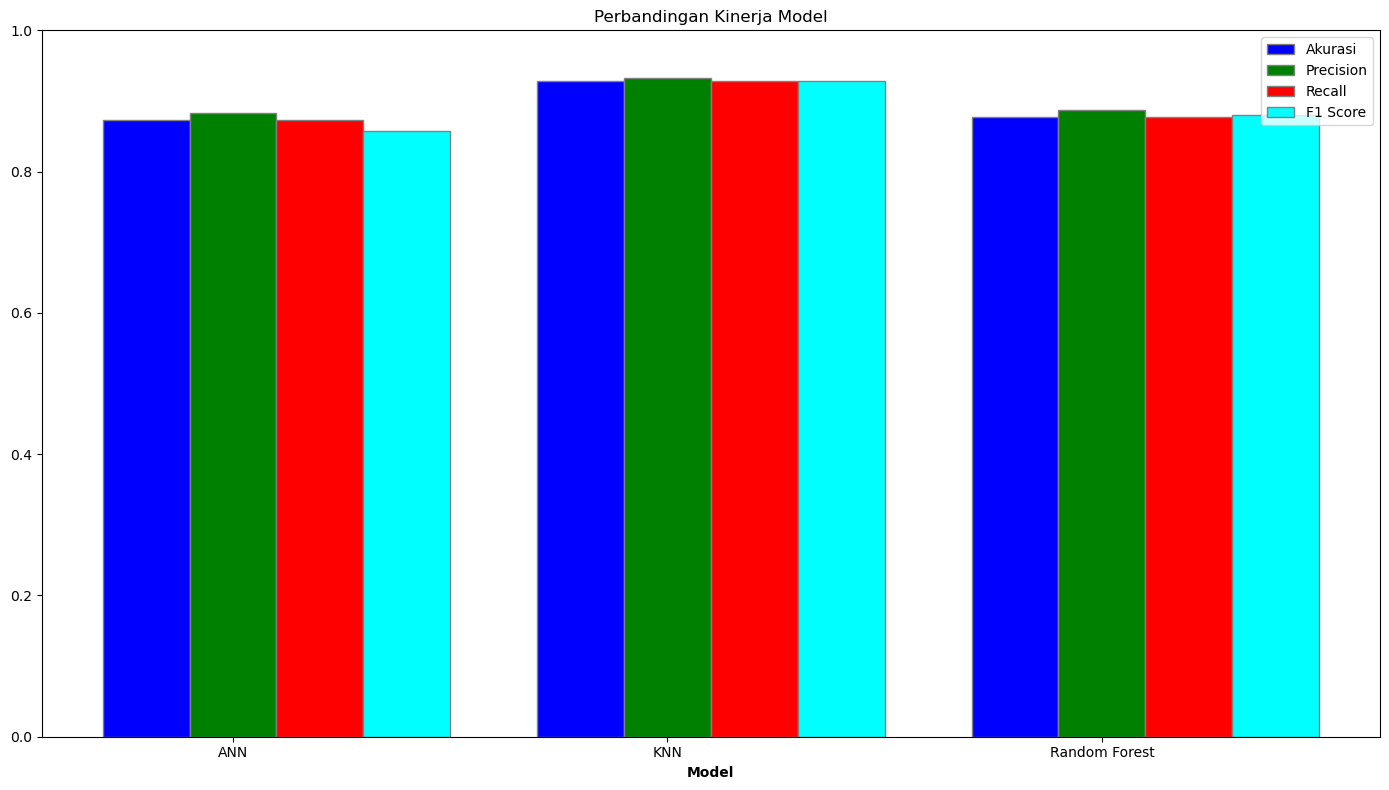

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Data untuk visualisasi
models = ['ANN', 'KNN', 'Random Forest']
accuracies = [accuracy_ann, accuracy_knn, accuracy_rf]
f1_scores = [f1_ann, f1_knn, f1_rf]
precisions = [precision_ann, precision_knn, precision_rf]
recalls = [recall_ann, recall_knn, recall_rf]

# Bar width
bar_width = 0.2

# Posisi untuk bar
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Ukuran figure
plt.figure(figsize=(14, 8))

# Membuat bar untuk masing-masing metrik
plt.bar(r1, accuracies, color='blue', width=bar_width, edgecolor='grey', label='Akurasi')
plt.bar(r2, precisions, color='green', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, recalls, color='red', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, f1_scores, color='cyan', width=bar_width, edgecolor='grey', label='F1 Score')

# Menambahkan label ke sumbu x
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)

# Menambahkan judul dan legend
plt.title('Perbandingan Kinerja Model')
plt.ylim([0, 1])
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()




In [68]:
import pickle

In [69]:
filename ="restaurant_model.sav"
pickle.dump(knn_pipeline, open(filename, 'wb') )